# 2D circle perimeter estimation using XGBoost
This is a simple notebook to demonstrate basic principles of machine learning classification model definition. The problem is to find that does a point in (x, y) space belong to circle perimeter line or not. The solution is a classification model that classifies the points to circle perimeter class (class 1) or background (class 0). In principle this is similar to many real world problem solving, where machine learning models are used to perform classification of a high-dimensional data. 

(c) Mikko Kursula 2019. MIT License. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

## Get input data and define the training target

In [2]:
def define_dataset(n_pts : int, 
                   radius : float = 0.7,
                   tolerance : float = 0.015) -> (np.ndarray, np.ndarray):
    """
    Get random numbers in the [-1, 1] range, arrange those to x, y coordinate 
    pairs and define the labels according to the coordinate location. Points 
    located on a (0, 0) centered circle perimeter line within small tolerance 
    will be labeled 1. All other points will be labeled 0. 
    Total n_pts points will be defined. 
    """
    
    # Define data
    data = np.random.rand(n_pts, 2) * 2 - 1

    # Define labeling
    radius_min = radius - tolerance
    radius_max = radius + tolerance
    radiuses = np.sqrt(data[:, 0] ** 2 + data[:, 1] ** 2)
    targets = []
    for radius in radiuses:
        if radius > radius_min and radius < radius_max:
            targets.append(1)
        else:
            targets.append(0)
    targets = np.array(targets).astype(np.int8)
    return data, targets
    
input_data, target = define_dataset(n_pts=10000)

## Visualize the data

In [3]:
def scatter_plot(input_data : np.ndarray, 
                 data_class : np.ndarray, 
                 figsize : tuple = (14, 11), 
                 cmap : str = 'bwr') -> None:
    """
    Plot all the points and color those according to the classifications. 
    The input_data must be numpy array with dimensions (samples, 2). The data_class must be numpy 
    array with dimension (samples) and the indexing must match to the input_data. 
    """
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.set_facecolor((0, 0, 0))
    plt.scatter(input_data[:, 0], input_data[:, 1], c=data_class, alpha=1, s=10, cmap=cmap, vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

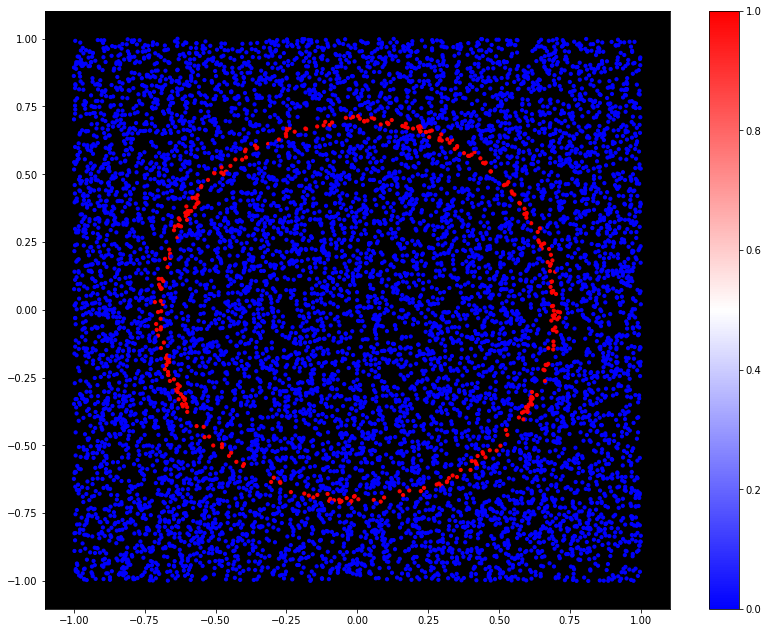

In [4]:
scatter_plot(input_data, target)

## Check class balance

In [5]:
n_neg = np.sum(target == 0)
n_pos = np.sum(target == 1)
print('Class 0 samples : {}'.format(n_neg))
print('Class 1 samples : {}'.format(n_pos))
print('Zero/one class ratio : {:.2f}'.format(n_neg / n_pos))

Class 0 samples : 9686
Class 1 samples : 314
Zero/one class ratio : 30.85


## Split dataset to train and validation and create XGBoost DMatrix objects

In [6]:
split_ratio = 0.7
split_idx = int(split_ratio * input_data.shape[0])
train_data = xgb.DMatrix(data=input_data[:split_idx], label=target[:split_idx])
eval_data = xgb.DMatrix(data=input_data[split_idx:], label=target[split_idx:])

## XGBoost model definition and training

In [7]:
params = {'max_depth' : 20, 
          'eta' : 0.5, 
          'scale_pos_weight' : 30,
          'objective' : 'binary:logistic' }

evals = [(eval_data, 'eval'), (train_data, 'train')]
eval_results = {}
n_round = 30

model = xgb.train(params=params, 
                  dtrain=train_data, 
                  num_boost_round=n_round, 
                  evals=evals, 
                  evals_result=eval_results, 
                  verbose_eval=False)

### Plot training results

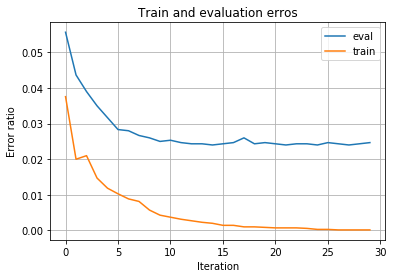

In [8]:
plt.figure()
plt.plot(eval_results['eval']['error'], label='eval')
plt.plot(eval_results['train']['error'], label='train')
plt.legend()
plt.ylabel('Error ratio')
plt.xlabel('Iteration')
plt.title('Train and evaluation erros')
plt.grid()
plt.show()

## Testing
This demonstrates simple classification quality evaluation and the typical pitfalls in using common metrics such as accuracy. 
Compare also the prediction scatter plots to the input dataset plot done earlier to visualize how the decision boundaries differ from the original data boundaries. 

In [9]:
# Get new data for testing 
test_data, test_target = define_dataset(10000)

# Make predictions using the trained model 
predictions = model.predict(xgb.DMatrix(test_data))

In [10]:
def evaluate_results(predictions : np.ndarray, 
                     targets : np.ndarray, 
                     class_threshold : float = 0.5) -> None:
    """
    Calculate the most basic model performance metrics. 
    """    
    predictions = (predictions > class_threshold) * 1
    true_neg = 0
    false_neg = 0
    true_pos = 0
    false_pos = 0
    
    for idx, prediction in enumerate(predictions):
        true = targets[idx]
        if true == 1 and prediction == 1: 
            true_pos += 1
            
        elif true == 0 and prediction == 1: 
            false_pos += 1
        
        elif true == 0 and prediction == 0: 
            true_neg += 1
        
        elif true == 1 and prediction == 0: 
            false_neg += 1

    # Calculate scores
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    accuracy = (true_pos + true_neg) / (true_pos + false_pos + true_neg + false_neg)    
    matthews_corr = (true_pos * true_neg - false_pos * false_neg) / (
                    (true_pos + false_pos) * (true_pos + false_neg) *
                    (true_neg + false_pos) * (true_neg + false_neg)) ** 0.5 
    f1_score = 2 * precision * recall / (precision + recall)

    print('Results')
    print('True class 1 \t {}'.format(true_pos))
    print('False class 1 \t {}'.format(false_pos))
    print('True class 0 \t {}'.format(true_neg))
    print('False class 0 \t {}'.format(false_neg))
    print('')
    print('Metrics:')
    print('Accuracy \t {:.3f}'.format(accuracy))
    print('Recall \t\t {:.3f}'.format(recall))
    print('Precision  \t {:.3f}'.format(precision))
    print('Matthews corr \t {:.3f}'.format(matthews_corr))
    print('F-1 score \t {:.3f}'.format(f1_score))
    
    
evaluate_results(predictions, test_target)

Results
True class 1 	 224
False class 1 	 148
True class 0 	 9517
False class 0 	 111

Metrics:
Accuracy 	 0.974
Recall 		 0.669
Precision  	 0.602
Matthews corr 	 0.621
F-1 score 	 0.634


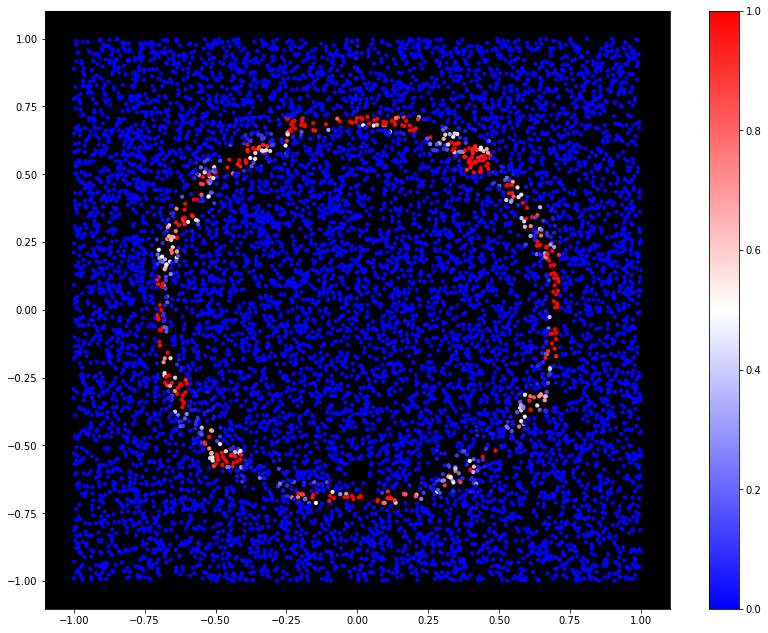

In [11]:
# Plot the prediction results 
scatter_plot(test_data, predictions)